In [187]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import ResNet50V2
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

### Preprossing the data with data augmentation

In [3]:
train_path = "../ASL_data_2/asl_alphabet_train/asl_alphabet_train/"
test_path = "../ASL_data_2/asl_alphabet_test/"

In [4]:
train_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1/255.0, 
    rotation_range=10,
    zoom_range = 0.10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=False,
    vertical_flip=False
)

test_generator = ImageDataGenerator(
    rescale=1/255.0
)

In [5]:
batch_size = 128
image_size = (128, 128)

In [148]:
train_data = train_generator.flow_from_directory(
    train_path, 
    batch_size=batch_size,
    shuffle=False, 
    subset="training",
    class_mode='categorical',
    target_size=image_size)

validation_data = train_generator.flow_from_directory(
    train_path, 
    batch_size=batch_size,
    shuffle=False, 
    subset="validation",
    class_mode='categorical',
    target_size=image_size)

Found 62400 images belonging to 26 classes.
Found 15600 images belonging to 26 classes.


In [7]:
test_data = test_generator.flow_from_directory(
    test_path,
    class_mode=None,
    target_size=image_size)

Found 26 images belonging to 1 classes.


In [8]:
classes = list(train_data.class_indices.keys())
num_classes  = len(classes)
print(f'{num_classes} Labels: {classes}')

26 Labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'nothing', 'space']


### CNN

In [57]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), activation='relu' ,padding='same', input_shape=(128, 128, 3)))
model_cnn.add(Conv2D(64, (3, 3), activation= 'relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_cnn.add(Conv2D(128, (3, 3), activation= 'relu'))
model_cnn.add(Conv2D(128, (3, 3), activation= 'relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_cnn.add(Conv2D(256, (3, 3), activation= 'relu'))
model_cnn.add(Conv2D(256, (3, 3), activation= 'relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [58]:
model_cnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 conv2d_146 (Conv2D)         (None, 126, 126, 64)      36928     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_147 (Conv2D)         (None, 61, 61, 128)       73856     
                                                                 
 conv2d_148 (Conv2D)         (None, 59, 59, 128)       147584    
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 29, 29, 128)      0         
 g2D)                                                

In [59]:
history_model_cnn = model_cnn.fit(
    train_data, 
    epochs=20,
    batch_size=batch_size,
    validation_data=validation_data,
)

Epoch 1/20
488/488 [==============================] - 4816s 10s/step - loss: 1.7739 - accuracy: 0.4622 - val_loss: 1.3802 - val_accuracy: 0.6122
Epoch 2/20
488/488 [==============================] - 4559s 9s/step - loss: 0.3275 - accuracy: 0.8910 - val_loss: 0.8847 - val_accuracy: 0.7603
Epoch 3/20
488/488 [==============================] - 4386s 9s/step - loss: 0.1522 - accuracy: 0.9493 - val_loss: 0.8132 - val_accuracy: 0.8067
Epoch 4/20
488/488 [==============================] - 4616s 9s/step - loss: 0.1015 - accuracy: 0.9666 - val_loss: 0.7808 - val_accuracy: 0.7924
Epoch 5/20
488/488 [==============================] - 4855s 10s/step - loss: 0.0763 - accuracy: 0.9751 - val_loss: 0.7675 - val_accuracy: 0.8196
Epoch 6/20
488/488 [==============================] - 4848s 10s/step - loss: 0.0637 - accuracy: 0.9796 - val_loss: 0.7361 - val_accuracy: 0.8340
Epoch 7/20
488/488 [==============================] - 4888s 10s/step - loss: 0.0502 - accuracy: 0.9838 - val_loss: 0.9186 - val_accur

In [149]:
model_cnn.evaluate(train_data)

488/488 [==============================] - 1064s 2s/step - loss: 0.0154 - accuracy: 0.9950


[0.015431497246026993, 0.9950320720672607]

In [150]:
y_pred_cnn_train = model_cnn.predict(train_data)
y_pred_cnn_test = model_cnn.predict(validation_data)

In [251]:
def metrics(y_true, y_pred):
    y_pred_array = np.array([np.argmax(x) for x in y_pred])
    metrics = {}
    accuracy = accuracy_score(y_true, y_pred_array)
    precision = precision_score(y_true, y_pred_array, average='macro')
    recall = recall_score(y_true, y_pred_array, average='macro')
    f1 = f1_score(y_true, y_pred_array, average='macro')
    metrics = {'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
               'f1':f1
              }
    return metrics

In [249]:
cnn_train_metrics = metrics(train_data.classes, y_pred_cnn_train)
cnn_test_metrics = metrics(validation_data.classes, y_pred_cnn_test)

In [246]:
cnn_train_metrics

{'accuracy': 0.994775641025641,
 'precision': 0.9947942163477462,
 'recall': 0.994775641025641,
 'f1': 0.9947723412440734}

In [250]:
cnn_test_metrics

{'accuracy': 0.8546794871794872,
 'precision': 0.8546794871794872,
 'recall': 0.8546794871794872,
 'f1': 0.8520749989707463}

### Accuracy: 99.48% train / 85.46% test

### Resnet50V2 with none of the layers trainable

In [9]:
resnet = ResNet50V2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

In [10]:
for layer in resnet.layers:
    layer.trainable = False

In [11]:
model_resnet = Sequential()

model_resnet.add(resnet)
model_resnet.add(Flatten())
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(num_classes, activation='softmax'))

model_resnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [13]:
history_resnet = model_resnet.fit(
    train_data, 
    epochs=20,
    batch_size=batch_size,
    validation_data=validation_data,
)

Epoch 1/20
488/488 [==============================] - 1141s 2s/step - loss: 0.6413 - accuracy: 0.8251 - val_loss: 0.8181 - val_accuracy: 0.7534
Epoch 2/20
488/488 [==============================] - 1157s 2s/step - loss: 0.2489 - accuracy: 0.9269 - val_loss: 0.7694 - val_accuracy: 0.7751
Epoch 3/20
488/488 [==============================] - 1147s 2s/step - loss: 0.1944 - accuracy: 0.9402 - val_loss: 0.7390 - val_accuracy: 0.7879
Epoch 4/20
488/488 [==============================] - 1089s 2s/step - loss: 0.1660 - accuracy: 0.9483 - val_loss: 0.7494 - val_accuracy: 0.7919
Epoch 5/20
488/488 [==============================] - 1049s 2s/step - loss: 0.1468 - accuracy: 0.9531 - val_loss: 0.7989 - val_accuracy: 0.7895
Epoch 6/20
488/488 [==============================] - 1024s 2s/step - loss: 0.1325 - accuracy: 0.9573 - val_loss: 0.7493 - val_accuracy: 0.8018
Epoch 7/20
488/488 [==============================] - 1085s 2s/step - loss: 0.1231 - accuracy: 0.9606 - val_loss: 0.7575 - val_accuracy:

In [154]:
y_pred_rnnotrain_train = model_resnet.predict(train_data)
y_pred_rnnotrain_test = model_resnet.predict(validation_data)

In [155]:
rnnotrain_train_metrics = metrics(train_data.classes, y_pred_rnnotrain_train)
rnnotrain_test_metrics = metrics(validation_data.classes, y_pred_rnnotrain_test)

In [156]:
rnnotrain_train_metrics

{'accuracy': 0.9941346153846153,
 'precision': 0.99414508889411,
 'recall': 0.9941346153846156,
 'f1': 0.9941305731737763}

In [157]:
rnnotrain_test_metrics

{'accuracy': 0.8155128205128205,
 'precision': 0.8276721163581247,
 'recall': 0.8155128205128205,
 'f1': 0.8132517001756691}

### Accuracy: 99.41% train / 81.55% test

#### Saving the model

In [16]:
model_resnet_json = model_resnet.to_json()

with open('resnet_no_trainable.json', 'w') as json_file:
    json_file.write(model_resnet_json)
model_resnet.save('resnet_no_trainable.h5')

### Resnet50V2 with the last block trainable

In [17]:
resnet_model = ResNet50V2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

#### Lets make the last block trainable

In [18]:
for layer in resnet_model.layers[:154]:
    layer.trainable = False

In [19]:
for i, layer in enumerate(resnet_model.layers[150:]):
    print(i+150, layer.name, '-', layer.trainable)

150 conv4_block6_2_relu - False
151 max_pooling2d_5 - False
152 conv4_block6_3_conv - False
153 conv4_block6_out - False
154 conv5_block1_preact_bn - True
155 conv5_block1_preact_relu - True
156 conv5_block1_1_conv - True
157 conv5_block1_1_bn - True
158 conv5_block1_1_relu - True
159 conv5_block1_2_pad - True
160 conv5_block1_2_conv - True
161 conv5_block1_2_bn - True
162 conv5_block1_2_relu - True
163 conv5_block1_0_conv - True
164 conv5_block1_3_conv - True
165 conv5_block1_out - True
166 conv5_block2_preact_bn - True
167 conv5_block2_preact_relu - True
168 conv5_block2_1_conv - True
169 conv5_block2_1_bn - True
170 conv5_block2_1_relu - True
171 conv5_block2_2_pad - True
172 conv5_block2_2_conv - True
173 conv5_block2_2_bn - True
174 conv5_block2_2_relu - True
175 conv5_block2_3_conv - True
176 conv5_block2_out - True
177 conv5_block3_preact_bn - True
178 conv5_block3_preact_relu - True
179 conv5_block3_1_conv - True
180 conv5_block3_1_bn - True
181 conv5_block3_1_relu - True
182 c

### Fine-tuning with the last block of the ResNET trainable

In [20]:
model_resnet_trainable = Sequential()

model_resnet_trainable.add(resnet_model)
model_resnet_trainable.add(Flatten())
model_resnet_trainable.add(BatchNormalization())
model_resnet_trainable.add(Dense(128, activation='relu'))
model_resnet_trainable.add(Dropout(0.5))
model_resnet_trainable.add(BatchNormalization())
model_resnet_trainable.add(Dense(num_classes, activation='softmax'))

model_resnet_trainable.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_resnet_trainable.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                      

In [22]:
history_resnet_trainable = model_resnet_trainable.fit(
    train_data, 
    epochs=20,
    batch_size=batch_size,
    validation_data=validation_data,
)

Epoch 1/20
488/488 [==============================] - 2205s 5s/step - loss: 0.2769 - accuracy: 0.9292 - val_loss: 0.4160 - val_accuracy: 0.8912
Epoch 2/20
488/488 [==============================] - 2171s 4s/step - loss: 0.0631 - accuracy: 0.9842 - val_loss: 0.4688 - val_accuracy: 0.8987
Epoch 3/20
488/488 [==============================] - 2104s 4s/step - loss: 0.0455 - accuracy: 0.9887 - val_loss: 0.4732 - val_accuracy: 0.8909
Epoch 4/20
488/488 [==============================] - 2106s 4s/step - loss: 0.0365 - accuracy: 0.9903 - val_loss: 0.5013 - val_accuracy: 0.9004
Epoch 5/20
488/488 [==============================] - 2104s 4s/step - loss: 0.0268 - accuracy: 0.9929 - val_loss: 0.4543 - val_accuracy: 0.9045
Epoch 6/20
488/488 [==============================] - 2103s 4s/step - loss: 0.0257 - accuracy: 0.9933 - val_loss: 0.4620 - val_accuracy: 0.9052
Epoch 7/20
488/488 [==============================] - 2106s 4s/step - loss: 0.0256 - accuracy: 0.9932 - val_loss: 0.4496 - val_accuracy:

In [24]:
model_resnet_trainable.evaluate(validation_data)

122/122 [==============================] - 215s 2s/step - loss: 0.4105 - accuracy: 0.9172


[0.41048672795295715, 0.9172435998916626]

In [158]:
y_pred_rntrain_train = model_resnet_trainable.predict(train_data)
y_pred_rntrain_test = model_resnet_trainable.predict(validation_data)

In [160]:
rntrain_train_metrics = metrics(train_data.classes, y_pred_rntrain_train)
rntrain_test_metrics = metrics(validation_data.classes, y_pred_rntrain_test)

In [161]:
rntrain_train_metrics

{'accuracy': 0.9989262820512821,
 'precision': 0.9989320739120701,
 'recall': 0.998926282051282,
 'f1': 0.9989261691047857}

In [162]:
rntrain_test_metrics

{'accuracy': 0.9186538461538462,
 'precision': 0.9237595403790968,
 'recall': 0.918653846153846,
 'f1': 0.9169702145544615}

### Accuracy: 99.89% train / 91.86% test

#### Adding a Learning Rate Decay

In [ ]:
model_decay = Sequential()

model_decay.add(resnet_model)
model_decay.add(Flatten())
model_decay.add(BatchNormalization())
model_decay.add(Dense(128, activation='relu'))
model_decay.add(Dropout(0.5))
model_decay.add(BatchNormalization())
model_decay.add(Dense(num_classes, activation='softmax'))

model_decay.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
lr_decay = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.00001)

In [19]:
history_decay = model_decay.fit(
    train_data, 
    epochs=20,
    batch_size=batch_size,
    validation_data=validation_data,
    callbacks=[lr_decay]
)

Epoch 1/20
488/488 [==============================] - 2342s 5s/step - loss: 0.2923 - accuracy: 0.9251 - val_loss: 0.4814 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 2/20
488/488 [==============================] - 2232s 5s/step - loss: 0.0634 - accuracy: 0.9841 - val_loss: 0.4844 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 3/20
488/488 [==============================] - 2235s 5s/step - loss: 0.0476 - accuracy: 0.9879 - val_loss: 0.5480 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 4/20
488/488 [==============================] - 2230s 5s/step - loss: 0.0369 - accuracy: 0.9904 - val_loss: 0.4358 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 5/20
488/488 [==============================] - 2232s 5s/step - loss: 0.0330 - accuracy: 0.9917 - val_loss: 0.5535 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 6/20
488/488 [==============================] - 2229s 5s/step - loss: 0.0273 - accuracy: 0.9928 - val_loss: 0.4564 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 7/20
488/488 [==============================] - ETA:

In [117]:
model_decay.evaluate(validation_data)

122/122 [==============================] - 255s 2s/step - loss: 0.4344 - accuracy: 0.9221


[0.43437081575393677, 0.9221153855323792]

In [116]:
model_decay = load_model('models/resnet_fine_tunned_lrdecay.h5')

In [159]:
y_pred_rntrainlrd_train = model_decay.predict(train_data)
y_pred_rntrainlrd_test = model_decay.predict(validation_data)

In [163]:
rntrainlrd_train_metrics = metrics(train_data.classes, y_pred_rntrainlrd_train)
rntrainlrd_test_metrics = metrics(validation_data.classes, y_pred_rntrainlrd_test)

In [164]:
rntrainlrd_train_metrics

{'accuracy': 0.9996634615384615,
 'precision': 0.9996637677800239,
 'recall': 0.9996634615384615,
 'f1': 0.9996634546378391}

In [166]:
rntrainlrd_test_metrics

{'accuracy': 0.9240384615384616,
 'precision': 0.9350750214930049,
 'recall': 0.9240384615384615,
 'f1': 0.9219503573432438}

### Accuracy: 99.96% train / 92.40% test

In [167]:
models_names = ['C6P2FC2', 'RNNOFT', 'RNFT', 'RNTLRD']
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

In [177]:
train_scores = pd.DataFrame(index = metrics_names, columns = models_names)
test_scores = pd.DataFrame(index = metrics_names, columns = models_names)

In [178]:
train_scores['C6P2FC2'] = cnn_train_metrics.values()
train_scores['RNNOFT'] = rnnotrain_train_metrics.values()
train_scores['RNFT'] = rntrain_train_metrics.values()
train_scores['RNTLRD'] = rntrainlrd_train_metrics.values()

In [179]:
test_scores['C6P2FC2'] = cnn_test_metrics.values()
test_scores['RNNOFT'] = rnnotrain_test_metrics.values()
test_scores['RNFT'] = rntrain_test_metrics.values()
test_scores['RNTLRD'] = rntrainlrd_test_metrics.values()

In [180]:
train_scores

,C6P2FC2,RNNOFT,RNFT,RNTLRD
Accuracy,0.994776,0.994135,0.998926,0.999663
Precision,0.994794,0.994145,0.998932,0.999664
Recall,0.994776,0.994135,0.998926,0.999663
F1-Score,0.994772,0.994131,0.998926,0.999663


In [181]:
test_scores

,C6P2FC2,RNNOFT,RNFT,RNTLRD
Accuracy,0.854679,0.815513,0.918654,0.924038
Precision,0.863764,0.827672,0.923760,0.935075
Recall,0.854679,0.815513,0.918654,0.924038
F1-Score,0.852075,0.813252,0.916970,0.921950


### Confusion matrix

In [201]:
train_data.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22,
 'Y': 23,
 'nothing': 24,
 'space': 25}

In [202]:
classes = list(train_data.class_indices.keys())

#### C6P2FC2

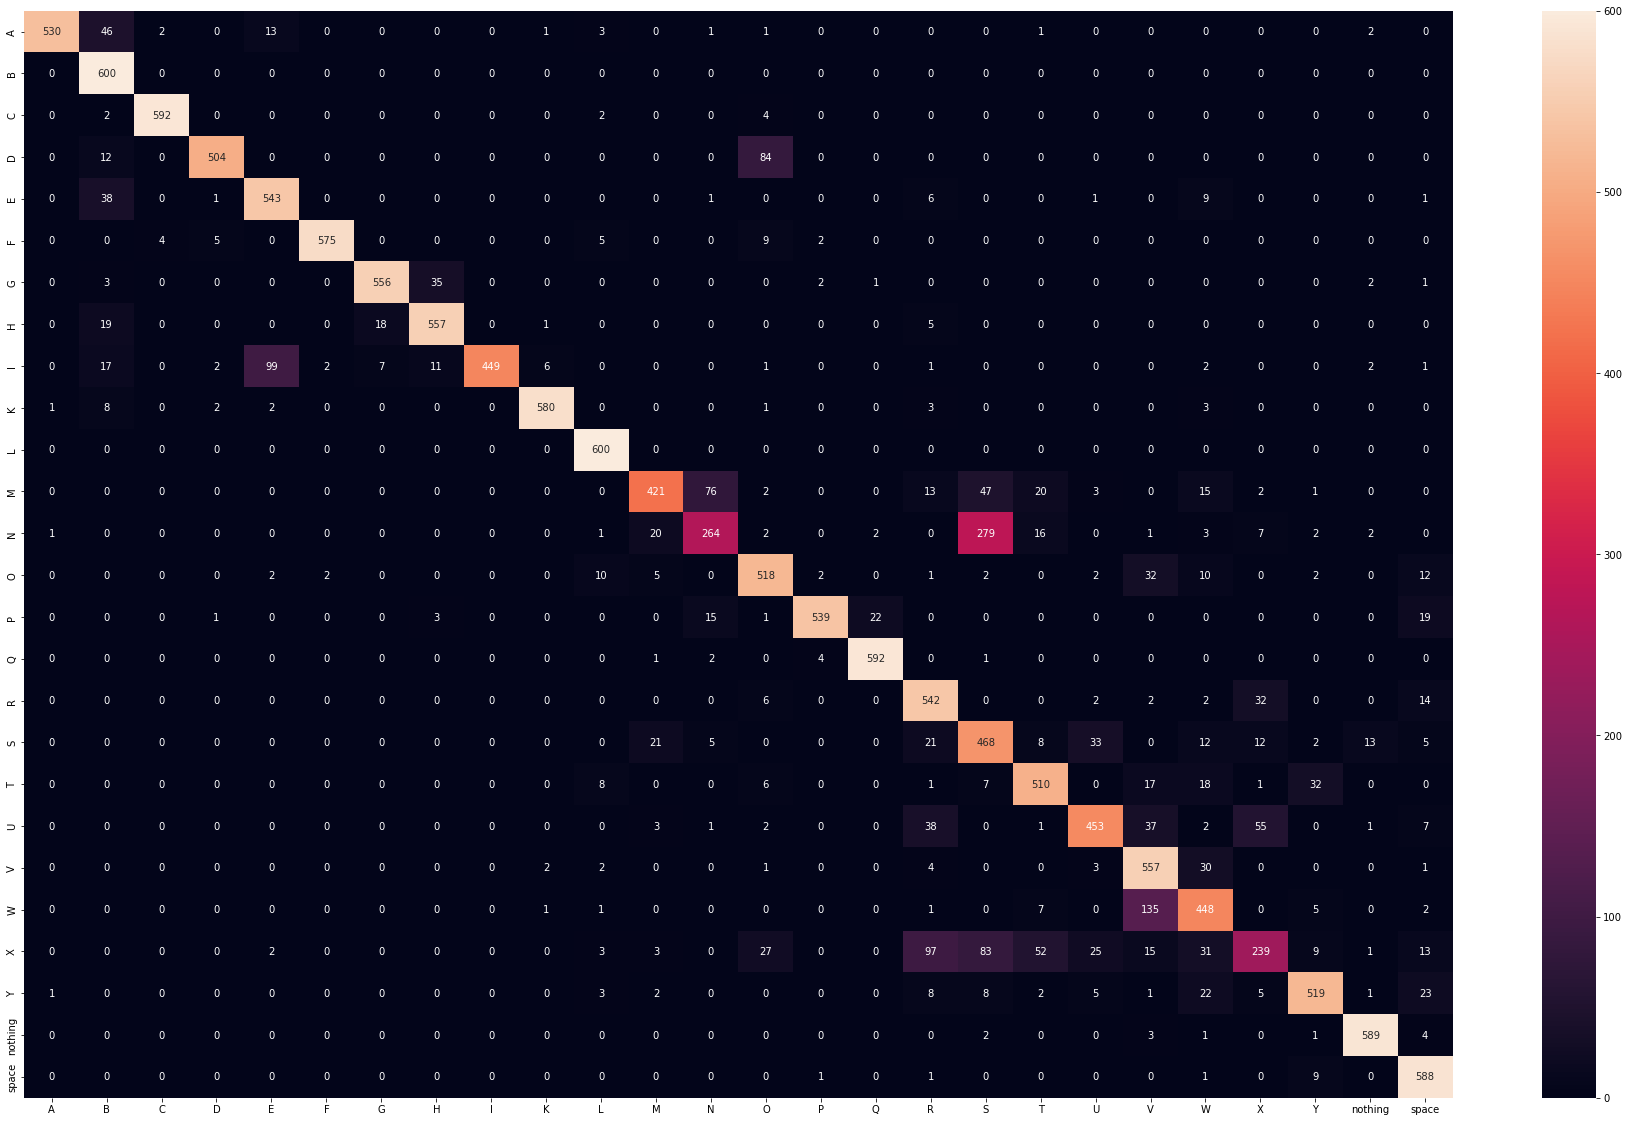

In [241]:
cm_c6p2fc2 = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_cnn_test]))
df_c6p2fc2 = pd.DataFrame(cm_c6p2fc2, index = classes,
                  columns = classes)
plt.figure(figsize = (32,20))
hm_c6p2fc2 = sn.heatmap(df_c6p2fc2, annot=True, fmt="d")
fig_c6p2fc2 = hm_c6p2fc2.get_figure()
fig_c6p2fc2.savefig('../images/TCC/c6p2fc2_cm.png', dpi=100)

#### RNNOFT

In [192]:
cm_rnnoft = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rnnotrain_test]))

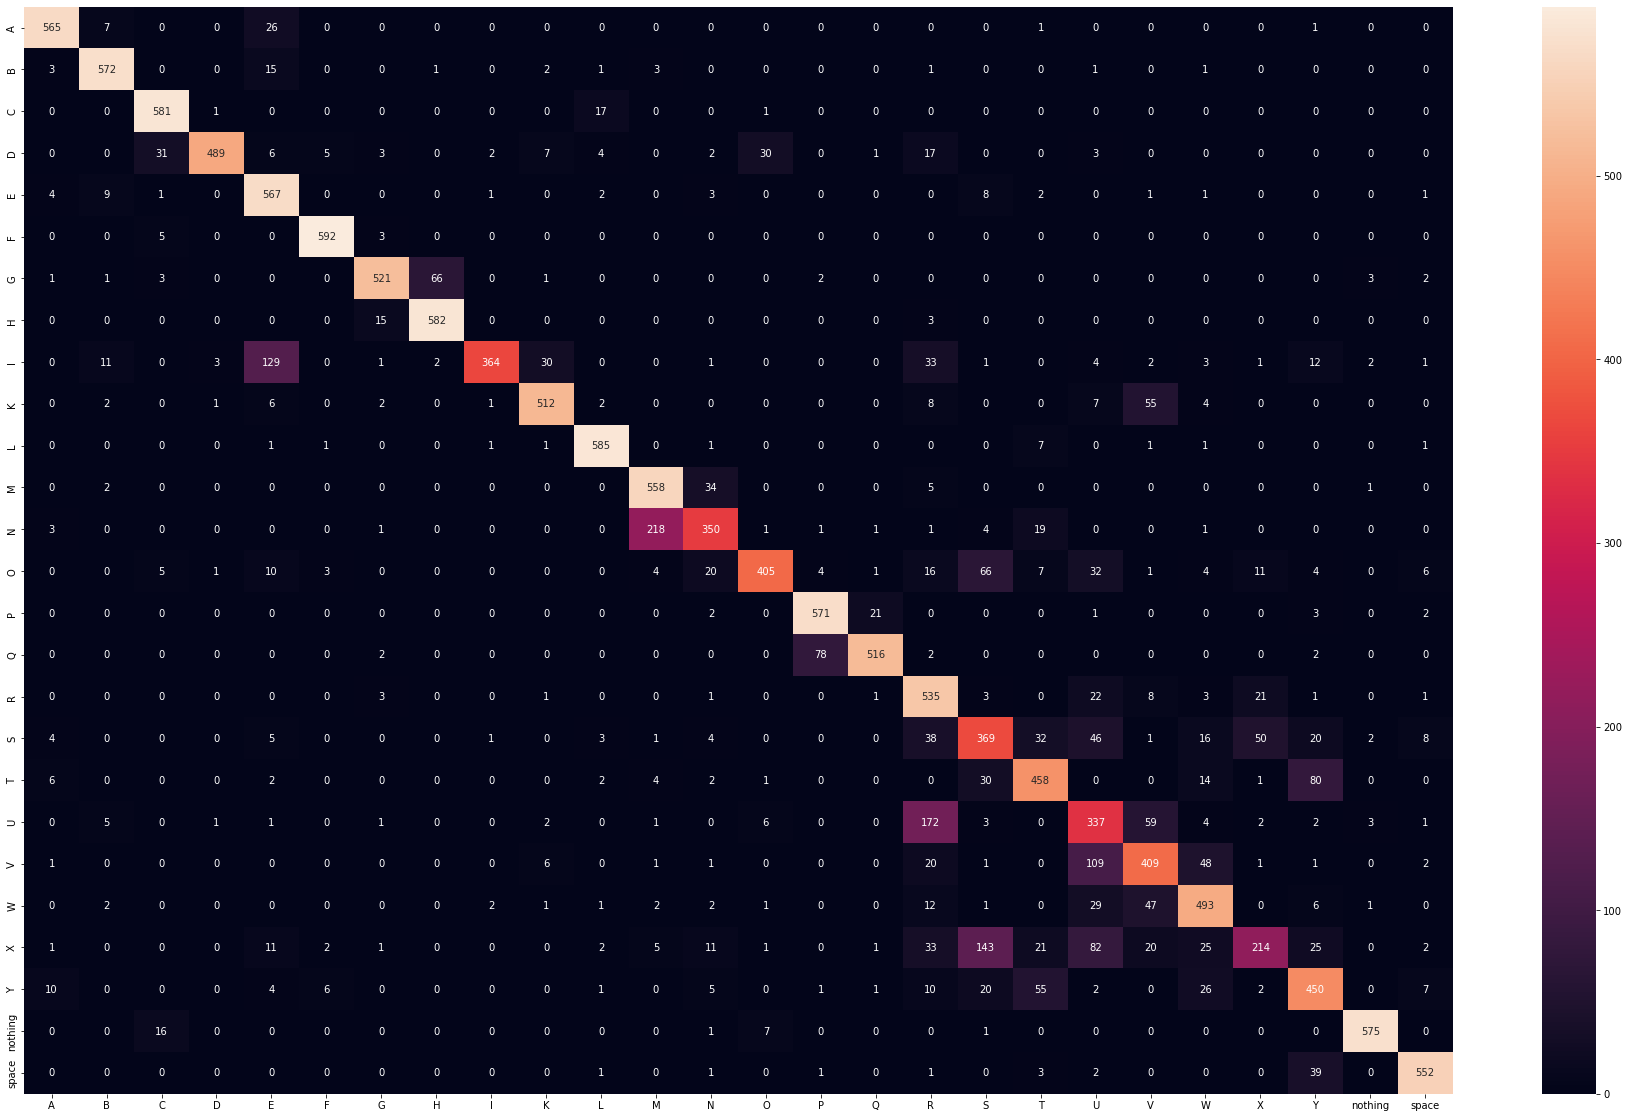

In [240]:
cm_rnnoft = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rnnotrain_test]))
df_rnnoft = pd.DataFrame(cm_rnnoft, index = classes,
                  columns = classes)
plt.figure(figsize = (32,20))
hm_rnnoft = sn.heatmap(df_rnnoft, annot=True, fmt="d")
fig_rnnoft = hm_rnnoft.get_figure()
fig_rnnoft.savefig('../images/TCC/rnnoft_cm.png', dpi=100)

#### RNFT

In [193]:
cm_rnft = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rntrain_test]))

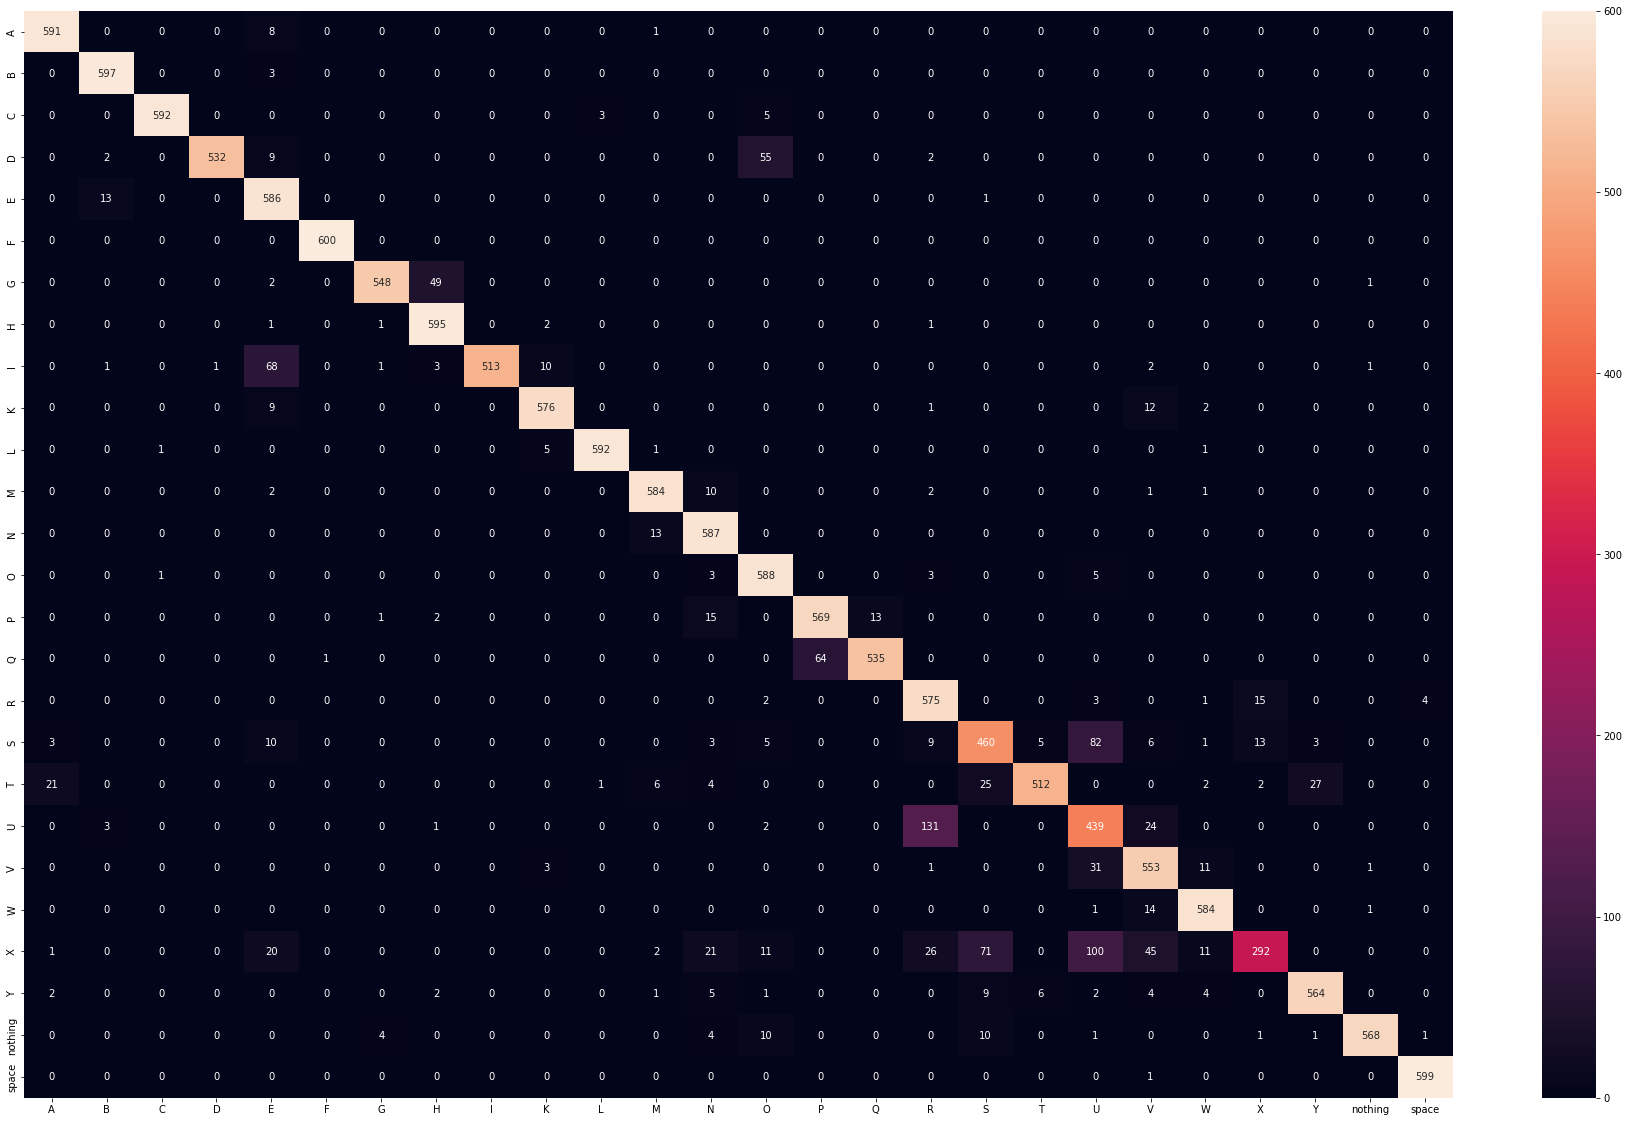

In [239]:
cm_rnft = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rntrain_test]))
df_rnft = pd.DataFrame(cm_rnft, index = classes,
                  columns = classes)
plt.figure(figsize = (32,20))
hm_rnft = sn.heatmap(df_rnft, annot=True, fmt="d")
fig_rnft = hm_rnft.get_figure()
fig_rnft.savefig('../images/TCC/rnft_cm.png', dpi=100)

#### RNFTLRD

In [194]:
cm_rnftlrd = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rntrainlrd_test]))

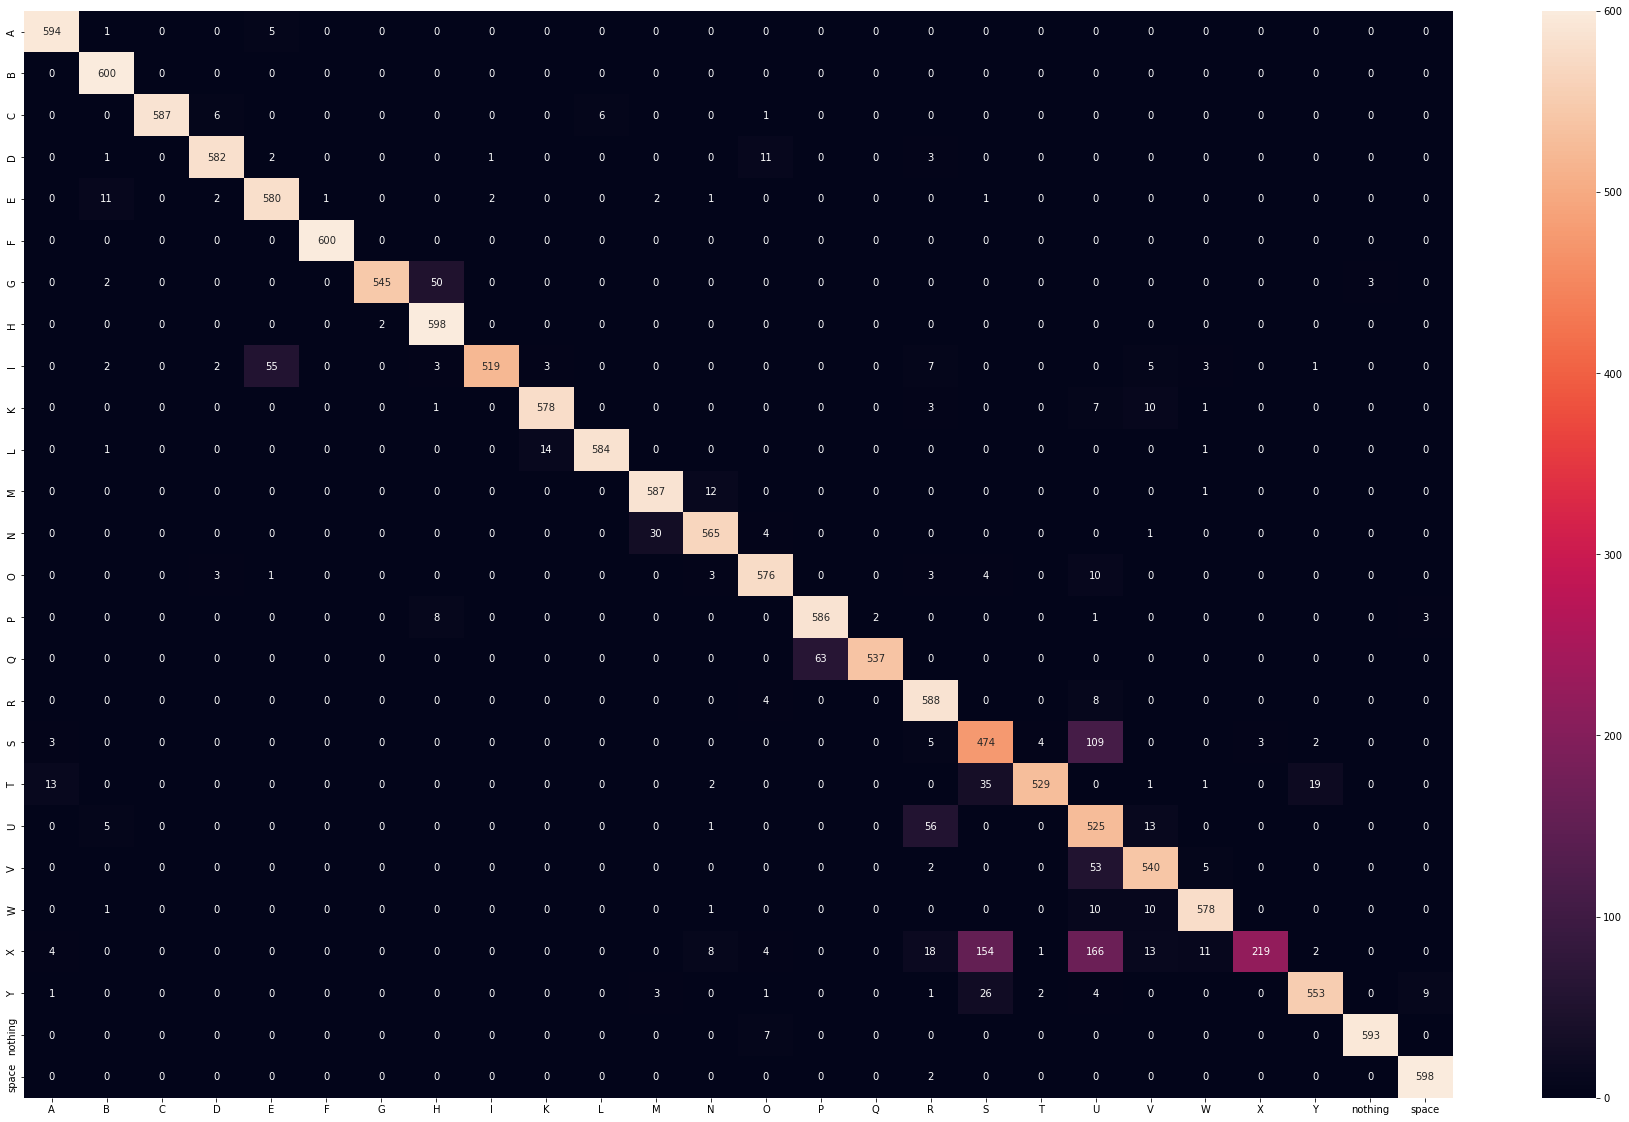

In [238]:
cm_rnftlrd = confusion_matrix(validation_data.classes, np.array([np.argmax(x) for x in y_pred_rntrainlrd_test]))
df_rnftlrd = pd.DataFrame(cm_rnftlrd, index = classes,
                  columns = classes)
plt.figure(figsize = (32,20))
hm_rnftlrd = sn.heatmap(df_rnftlrd, annot=True, fmt="d")
fig_rnftlrd = hm_rnftlrd.get_figure()
fig_rnftlrd.savefig('../images/TCC/rnftlrd_cm.png', dpi=100)